In [156]:
import numpy as np
from numpy import array

import random
from random import randint
import os

import matplotlib.pyplot as plt
import pandas as pd

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Activation, MaxPooling1D, Dropout
from keras.optimizers import SGD

In [157]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [158]:
              """Hyperparameters"""
w = 17280-500                 # History window (number of time stamps taken into account) 
                         # i.e., filter(kernel) size       
p_w = 500                # Prediction window (number of time stampes required to be 
                         # predicted)
n_features = 1           # Univariate time series

kernel_size = 2          # Size of filter in conv layers
num_filt_1 = 32          # Number of filters in first conv layer
num_filt_2 = 32          # Number of filters in second conv layer
num_nrn_dl = 40          # Number of neurons in dense layer
num_nrn_ol = p_w        # Number of neurons in output layer

conv_strides = 1
pool_size_1 = 2          # Length of window of pooling layer 1
pool_size_2 = 2          # Length of window of pooling layer 2
pool_strides_1 = 2       # Stride of window of pooling layer 1
pool_strides_2 = 2       # Stride of window of pooling layer 2

epochs = 30
dropout_rate = 0.5       # Dropout rate in the fully connected layer
learning_rate = 2e-5  
anm_det_thr = 0.8        # Threshold for classifying anomaly (0.5~0.8)

In [159]:
from hdf_helper import *
from stat_helper import *
from data_cleaning import *

import h5py

In [160]:
#df = pd.read_csv('data/datch_3.csv').drop(['Unnamed: 0'], axis = 1)

df_test = pd.read_csv('data/dat_ch_3_no_outliers.csv', nrows=100)

float_cols = [c for i, c in enumerate(df_test.columns) if i != 0]
float64_cols = {c: np.float64 for c in float_cols}

df = pd.read_csv('data/datch_3.csv', engine='c', dtype=float64_cols).drop(['Unnamed: 0'], axis = 1)
df = df.replace(np.NAN, 0.0)

zero_outliers = df.loc[:, (df == 0.0).all(axis=0)]
reg_data = df.loc[:,(df != 0.0).any(axis=0)]

#df = reduce_dataset_size(df, cluster_size = 50)
df = smooth_values(df)
scaler = RobustScaler()
df = pd.DataFrame(scaler.fit_transform(df))


In [161]:
w = len(df.index) - 500

In [162]:
"""
Data preprocessing


"""
# split a univariate sequence into samples
def split_sequence(sequence):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + w
        out_end_ix = end_ix + p_w
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
    # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [163]:
# # define input sequence
# for col in reg_data.columns:
#     sampl, labl = split_sequence(list(reg_data[col]))
samples = []
labels = []

batch_sampl, batch_labl = split_sequence(list(reg_data.ix[:,0]))
samples.append(batch_sampl)
labels.append(batch_labl)

print()

for i in range(1, len(reg_data.columns)):
    batch_sampl, batch_labl = split_sequence(list(reg_data.ix[:,i]))
    samples.append(batch_sampl)
    labels.append(batch_labl)
    
batch_sample = np.array(samples)
batch_label = np.array(labels)
    
print(batch_sample.shape)

# summarize the data
# for i in range(5):
#     print(X[i], Y[i])
  
# 2. reshape from [samples, timesteps] into [samples, timesteps, features]

# need to convert batch into 3D tensor of the form [batch_size, input_seq_len, n_features]
batch_sample = batch_sample.reshape((batch_sample.shape[0], batch_sample.shape[2], n_features))


(27, 1, 16780)


C:\Users\smoor\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys
C:\Users\smoor\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [164]:
batch_label = batch_label.reshape((batch_label.shape[0],batch_label.shape[1],batch_label.shape[2]))
print(batch_label.shape)
print(batch_sample.shape)

(27, 1, 500)
(27, 16780, 1)


In [165]:
              """Generate model for predictor"""
model = Sequential()

# Convolutional Layer #1
# Computes 32 features using a 1D filter(kernel) of with w with ReLU activation. 
# Padding is added to preserve width.
# Input Tensor Shape: [batch_size, w, 1] / batch_size = len(batch_sample)
# Output Tensor Shape: [batch_size, w, num_filt_1] (num_filt_1 = 32 feature vectors)
model.add(Conv1D(filters=num_filt_1,
                 kernel_size=kernel_size,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu',
                 input_shape=(w, n_features)))

# Pooling Layer #1
# First max pooling layer with a filter of length 2 and stride of 2
# Input Tensor Shape: [batch_size, w, num_filt_1]
# Output Tensor Shape: [batch_size, 0.5 * w, num_filt_1]

model.add(MaxPooling1D(pool_size=pool_size_1)) 
                    #  strides=pool_strides_1, 
                    #  padding='valid'))

# Convolutional Layer #2
# Computes 64 features using a 5x5 filter.
# Padding is added to preserve width and height.
# Input Tensor Shape: [batch_size, 0.5 * w, 32]
# Output Tensor Shape: [batch_size, 0.5 * w, num_filt_1 * num_filt_2]
model.add(Conv1D(filters=num_filt_2,
                 kernel_size=kernel_size,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu'))

# Max Pooling Layer #2
# Second max pooling layer with a 2x2 filter and stride of 2
# Input Tensor Shape: [batch_size, 0.5 * w, num_filt_1 * num_filt_2]
# Output Tensor Shape: [batch_size, 0.25 * w, num_filt_1 * num_filt_2]
model.add(MaxPooling1D(pool_size=pool_size_2))
                    #  strides=pool_strides_2, 
                    #  padding='valid'
          
# Flatten tensor into a batch of vectors
# Input Tensor Shape: [batch_size, 0.25 * w, num_filt_1 * num_filt_2]
# Output Tensor Shape: [batch_size, 0.25 * w * num_filt_1 * num_filt_2]
model.add(Flatten())

# Dense Layer (Output layer)
# Densely connected layer with 1024 neurons
# Input Tensor Shape: [batch_size, 0.25 * w * num_filt_1 * num_filt_2]
# Output Tensor Shape: [batch_size, 1024]
model.add(Dense(units=num_nrn_dl, activation='relu'))  

# Dropout
# Prevents overfitting in deep neural networks
model.add(Dropout(dropout_rate))

# Output layer
# Input Tensor Shape: [batch_size, 1024]
# Output Tensor Shape: [batch_size, p_w]
model.add(Dense(units=num_nrn_ol))

# Summarize model structure
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_38 (Conv1D)           (None, 16779, 32)         96        
_________________________________________________________________
max_pooling1d_38 (MaxPooling (None, 8389, 32)          0         
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 8388, 32)          2080      
_________________________________________________________________
max_pooling1d_39 (MaxPooling (None, 4194, 32)          0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 134208)            0         
_________________________________________________________________
dense_38 (Dense)             (None, 40)                5368360   
_________________________________________________________________
dropout_19 (Dropout)         (None, 40)              

In [166]:
                 '''configure model'''
model.compile(optimizer='adam', 
              loss='mean_absolute_error')

# sgd = keras.optimizers.SGD(lr=learning_rate, 
#                          decay=1e-6, 
#                          momentum=0.9, 
#                          nesterov=True)
# model.compile(optimizer='sgd', 
#               loss='mean_absolute_error', 
#               metrics=['accuracy'])

In [167]:
'''

model_fit = model.fit(batch_sample,
                      batch_label,
                      epochs=epochs,
                      verbose=1)
'''

'\n\nmodel_fit = model.fit(batch_sample,\n                      batch_label,\n                      epochs=epochs,\n                      verbose=1)\n'

In [168]:
for i in range(len(reg_data.columns)):
    sampl = batch_sample[i].reshape((1,batch_sample.shape[1],batch_sample.shape[2]))
    print(sampl.shape)
    labl = batch_label[i].reshape((batch_label.shape[1],batch_label.shape[2]))
    model.fit(sampl,
                          labl,
                          epochs=epochs,
                          verbose=1)

(1, 16780, 1)
Epoch 1/30
1/1 [==============================] - 0s 479ms/step - loss: 0.1092
Epoch 2/30
1/1 [==============================] - 0s 50ms/step - loss: 0.1727
Epoch 3/30
1/1 [==============================] - 0s 52ms/step - loss: 0.1107
Epoch 4/30
1/1 [==============================] - 0s 55ms/step - loss: 0.0186
Epoch 5/30
1/1 [==============================] - 0s 57ms/step - loss: 0.0092
Epoch 6/30
1/1 [==============================] - 0s 61ms/step - loss: 0.0023
Epoch 7/30
1/1 [==============================] - 0s 58ms/step - loss: 0.0022
Epoch 8/30
1/1 [==============================] - 0s 63ms/step - loss: 0.0021
Epoch 9/30
1/1 [==============================] - 0s 56ms/step - loss: 0.0028
Epoch 10/30
1/1 [==============================] - 0s 56ms/step - loss: 0.0017
Epoch 11/30
1/1 [==============================] - 0s 56ms/step - loss: 0.0015
Epoch 12/30
1/1 [==============================] - 0s 55ms/step - loss: 0.0012
Epoch 13/30
1/1 [=============================

Epoch 11/30
1/1 [==============================] - 0s 48ms/step - loss: 2.1275e-04
Epoch 12/30
1/1 [==============================] - 0s 48ms/step - loss: 2.1221e-04
Epoch 13/30
1/1 [==============================] - 0s 48ms/step - loss: 2.0056e-04
Epoch 14/30
1/1 [==============================] - 0s 48ms/step - loss: 2.0189e-04
Epoch 15/30
1/1 [==============================] - 0s 53ms/step - loss: 2.0560e-04
Epoch 16/30
1/1 [==============================] - 0s 48ms/step - loss: 1.9012e-04
Epoch 17/30
1/1 [==============================] - 0s 52ms/step - loss: 1.7924e-04
Epoch 18/30
1/1 [==============================] - 0s 52ms/step - loss: 1.6914e-04
Epoch 19/30
1/1 [==============================] - 0s 47ms/step - loss: 1.6049e-04
Epoch 20/30
1/1 [==============================] - 0s 57ms/step - loss: 1.5599e-04
Epoch 21/30
1/1 [==============================] - 0s 54ms/step - loss: 1.6895e-04
Epoch 22/30
1/1 [==============================] - 0s 53ms/step - loss: 1.7082e-04
Epoc

Epoch 21/30
1/1 [==============================] - 0s 53ms/step - loss: 0.5070
Epoch 22/30
1/1 [==============================] - 0s 52ms/step - loss: 0.5070
Epoch 23/30
1/1 [==============================] - 0s 53ms/step - loss: 0.5070
Epoch 24/30
1/1 [==============================] - 0s 53ms/step - loss: 0.5070
Epoch 25/30
1/1 [==============================] - 0s 54ms/step - loss: 0.5069
Epoch 26/30
1/1 [==============================] - 0s 52ms/step - loss: 0.5069
Epoch 27/30
1/1 [==============================] - 0s 52ms/step - loss: 0.5069
Epoch 28/30
1/1 [==============================] - 0s 53ms/step - loss: 0.5069
Epoch 29/30
1/1 [==============================] - 0s 55ms/step - loss: 0.5069
Epoch 30/30
1/1 [==============================] - 0s 53ms/step - loss: 0.5069
(1, 16780, 1)
Epoch 1/30
1/1 [==============================] - 0s 57ms/step - loss: 15.4714
Epoch 2/30
1/1 [==============================] - 0s 52ms/step - loss: 15.3773
Epoch 3/30
1/1 [======================

1/1 [==============================] - 0s 53ms/step - loss: 3.6719e-04
Epoch 4/30
1/1 [==============================] - 0s 58ms/step - loss: 3.4427e-04
Epoch 5/30
1/1 [==============================] - 0s 52ms/step - loss: 3.2113e-04
Epoch 6/30
1/1 [==============================] - 0s 52ms/step - loss: 2.9152e-04
Epoch 7/30
1/1 [==============================] - 0s 47ms/step - loss: 2.6122e-04
Epoch 8/30
1/1 [==============================] - 0s 51ms/step - loss: 2.3052e-04
Epoch 9/30
1/1 [==============================] - 0s 52ms/step - loss: 2.1159e-04
Epoch 10/30
1/1 [==============================] - 0s 51ms/step - loss: 1.8832e-04
Epoch 11/30
1/1 [==============================] - 0s 51ms/step - loss: 1.8511e-04
Epoch 12/30
1/1 [==============================] - 0s 48ms/step - loss: 1.9157e-04
Epoch 13/30
1/1 [==============================] - 0s 51ms/step - loss: 1.9636e-04
Epoch 14/30
1/1 [==============================] - 0s 50ms/step - loss: 2.0021e-04
Epoch 15/30
1/1 [=====

Epoch 12/30
1/1 [==============================] - 0s 52ms/step - loss: 1.2195e-04
Epoch 13/30
1/1 [==============================] - 0s 56ms/step - loss: 1.2175e-04
Epoch 14/30
1/1 [==============================] - 0s 54ms/step - loss: 1.2207e-04
Epoch 15/30
1/1 [==============================] - 0s 52ms/step - loss: 1.2278e-04
Epoch 16/30
1/1 [==============================] - 0s 50ms/step - loss: 1.1827e-04
Epoch 17/30
1/1 [==============================] - 0s 53ms/step - loss: 1.1825e-04
Epoch 18/30
1/1 [==============================] - 0s 65ms/step - loss: 1.1835e-04
Epoch 19/30
1/1 [==============================] - 0s 51ms/step - loss: 1.2218e-04
Epoch 20/30
1/1 [==============================] - 0s 49ms/step - loss: 1.1833e-04
Epoch 21/30
1/1 [==============================] - 0s 55ms/step - loss: 1.1325e-04
Epoch 22/30
1/1 [==============================] - 0s 54ms/step - loss: 1.1318e-04
Epoch 23/30
1/1 [==============================] - 0s 53ms/step - loss: 1.2094e-04
Epoc

Epoch 21/30
1/1 [==============================] - 0s 56ms/step - loss: 1.1812e-04
Epoch 22/30
1/1 [==============================] - 0s 52ms/step - loss: 1.1778e-04
Epoch 23/30
1/1 [==============================] - 0s 48ms/step - loss: 1.1244e-04
Epoch 24/30
1/1 [==============================] - 0s 52ms/step - loss: 1.1661e-04
Epoch 25/30
1/1 [==============================] - 0s 53ms/step - loss: 1.1769e-04
Epoch 26/30
1/1 [==============================] - 0s 51ms/step - loss: 1.1079e-04
Epoch 27/30
1/1 [==============================] - 0s 56ms/step - loss: 1.0997e-04
Epoch 28/30
1/1 [==============================] - 0s 51ms/step - loss: 1.1606e-04
Epoch 29/30
1/1 [==============================] - 0s 55ms/step - loss: 1.3068e-04
Epoch 30/30
1/1 [==============================] - 0s 53ms/step - loss: 1.2300e-04
(1, 16780, 1)
Epoch 1/30
1/1 [==============================] - 0s 53ms/step - loss: 1.1543e-04
Epoch 2/30
1/1 [==============================] - 0s 52ms/step - loss: 1.1

Epoch 30/30
1/1 [==============================] - 0s 59ms/step - loss: 1.2016e-04
(1, 16780, 1)
Epoch 1/30
1/1 [==============================] - 0s 53ms/step - loss: 1.1835e-04
Epoch 2/30
1/1 [==============================] - 0s 59ms/step - loss: 1.1753e-04
Epoch 3/30
1/1 [==============================] - 0s 52ms/step - loss: 1.1909e-04
Epoch 4/30
1/1 [==============================] - 0s 57ms/step - loss: 1.2253e-04
Epoch 5/30
1/1 [==============================] - 0s 55ms/step - loss: 1.2157e-04
Epoch 6/30
1/1 [==============================] - 0s 57ms/step - loss: 1.1944e-04
Epoch 7/30
1/1 [==============================] - 0s 63ms/step - loss: 1.2267e-04
Epoch 8/30
1/1 [==============================] - 0s 105ms/step - loss: 1.2021e-04
Epoch 9/30
1/1 [==============================] - 0s 73ms/step - loss: 1.1973e-04
Epoch 10/30
1/1 [==============================] - 0s 58ms/step - loss: 1.2060e-04
Epoch 11/30
1/1 [==============================] - 0s 50ms/step - loss: 1.1960e-0

Epoch 9/30
1/1 [==============================] - 0s 48ms/step - loss: 1.1012e-04
Epoch 10/30
1/1 [==============================] - 0s 54ms/step - loss: 1.1104e-04
Epoch 11/30
1/1 [==============================] - 0s 51ms/step - loss: 1.1613e-04
Epoch 12/30
1/1 [==============================] - 0s 52ms/step - loss: 1.1806e-04
Epoch 13/30
1/1 [==============================] - 0s 48ms/step - loss: 1.1564e-04
Epoch 14/30
1/1 [==============================] - 0s 52ms/step - loss: 1.1256e-04
Epoch 15/30
1/1 [==============================] - 0s 52ms/step - loss: 1.1425e-04
Epoch 16/30
1/1 [==============================] - 0s 60ms/step - loss: 1.1486e-04
Epoch 17/30
1/1 [==============================] - 0s 66ms/step - loss: 1.2132e-04
Epoch 18/30
1/1 [==============================] - 0s 48ms/step - loss: 1.1610e-04
Epoch 19/30
1/1 [==============================] - 0s 47ms/step - loss: 1.1895e-04
Epoch 20/30
1/1 [==============================] - 0s 72ms/step - loss: 1.1456e-04
Epoch

Epoch 18/30
1/1 [==============================] - 0s 55ms/step - loss: 1.2575e-04
Epoch 19/30
1/1 [==============================] - 0s 58ms/step - loss: 1.1838e-04
Epoch 20/30
1/1 [==============================] - 0s 52ms/step - loss: 1.1859e-04
Epoch 21/30
1/1 [==============================] - 0s 52ms/step - loss: 1.1624e-04
Epoch 22/30
1/1 [==============================] - 0s 56ms/step - loss: 1.1953e-04
Epoch 23/30
1/1 [==============================] - 0s 52ms/step - loss: 1.2530e-04
Epoch 24/30
1/1 [==============================] - 0s 57ms/step - loss: 1.1990e-04
Epoch 25/30
1/1 [==============================] - 0s 55ms/step - loss: 1.1900e-04
Epoch 26/30
1/1 [==============================] - 0s 51ms/step - loss: 1.1510e-04
Epoch 27/30
1/1 [==============================] - 0s 57ms/step - loss: 1.1214e-04
Epoch 28/30
1/1 [==============================] - 0s 54ms/step - loss: 1.1454e-04
Epoch 29/30
1/1 [==============================] - 0s 54ms/step - loss: 1.1654e-04
Epoc

In [143]:
                 """Testing with random interval(DeepAnT)"""
# Set number of test sequences 
n_test_seq = 1

# Split a univariate sequence into samples
def generate_test_batch(raw_seq, n_test_seq):
  # Sample a portion of the raw_seq randomly
    ran_ix = random.randint(0,len(raw_seq) - n_test_seq * w - n_test_seq * p_w)
    raw_test_seq = array(raw_seq[ran_ix:ran_ix + n_test_seq * w +  n_test_seq * p_w])
    batch_test_seq, batch_test_label = list(), list()
    ix = ran_ix
    for i in range(n_test_seq):
        # gather input and output parts of the pattern
        seq_x = raw_seq[ix : ix+w],
        seq_y = raw_seq[ix+w : ix+w+p_w]
        ix = ix+w+p_w
        batch_test_seq.append(seq_x)
        batch_test_label.append(seq_y)
    return array(batch_test_seq), array(batch_test_label)

batch_test_seq, batch_test_label = generate_test_batch(list(reg_data.ix[:,0]), n_test_seq)
batch_test_seq = batch_test_seq.reshape((batch_test_seq.shape[0], w, n_features))
batch_test_label = batch_test_label.reshape((batch_test_label.shape[0], p_w))

# Returns the loss value & metrics values for the model in test mode
model.evaluate(x=batch_test_seq,
               y=batch_test_label,
               verbose=1) 

1/1 [==============================] - 0s 141ms/step


C:\Users\smoor\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


0.00011356545292073861

In [144]:
               """Save Weights (DeepAnT)"""
# save it to disk so we can load it back up anytime
model.save_weights('ch_3_noanom_weights.h5')  

In [146]:
            """Predicting random intervals (DeepAnT)"""
# Build model 
model = Sequential()
model.add(Conv1D(filters=num_filt_1,
                 kernel_size=kernel_size,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu',
                 input_shape=(w, n_features)))
model.add(MaxPooling1D(pool_size=pool_size_1)) 
model.add(Conv1D(filters=num_filt_2,
                 kernel_size=kernel_size,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu'))
model.add(MaxPooling1D(pool_size=pool_size_2))
model.add(Flatten())
model.add(Dense(units=num_nrn_dl, activation='relu')) 
model.add(Dropout(dropout_rate))
model.add(Dense(units=num_nrn_ol))

# Load the model's saved weights.
model.load_weights('ch_1_weights.h5')
          
# Sample a portion of the raw_seq randomly
# 1. Choose 
ran_ix = random.randint(1,len(raw_seq) - w - p_w)
input_seq = array(raw_seq[ran_ix : ran_ix + w])
target_seq = array(raw_seq[ran_ix + w : ran_ix + w + p_w])
input_seq = input_seq.reshape((1, w, n_features))

# Predict the next time stampes of the sampled sequence
yhat = model.predict(input_seq, verbose=1)

# Print our model's predictions.
print(yhat)

# Check our predictions against the ground truths.
print(target_seq) # [7, 2, 1, 0, 4]

ValueError: empty range for randrange() (1,-17270, -17271)

In [147]:
            """Predicting future sequence (DeepAnT)"""
# Build model 
model = Sequential()
model.add(Conv1D(filters=num_filt_1,
                 kernel_size=kernel_size,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu',
                 input_shape=(w, n_features)))
model.add(MaxPooling1D(pool_size=pool_size_1)) 
model.add(Conv1D(filters=num_filt_2,
                 kernel_size=kernel_size,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu'))
model.add(MaxPooling1D(pool_size=pool_size_2))
model.add(Flatten())
model.add(Dense(units=num_nrn_dl, activation='relu')) 
model.add(Dropout(dropout_rate))
model.add(Dense(units=num_nrn_ol))

# Load the model's saved weights.
model.load_weights('ch_1_weights.h5')
          
    
raw_seq = list(reg_data.ix[:,0])
endix = len(raw_seq) - w - p_w
input_seq = array(raw_seq[endix:endix+w])
target_seq = array(raw_seq[endix+w:endix+w+p_w]) 
input_seq = input_seq.reshape((1, w, n_features))

# Predict the next time stampes of the sampled sequence
predicted_seq = model.predict(input_seq, verbose=1)

# Print our model's predictions.
print(predicted_seq)

# Check our predictions against the ground truths.
print(target_seq) # [7, 2, 1, 0, 4]

1/1 [==============================] - 0s 132ms/step
[[ 3.82821381e-05  2.72709382e-04 -1.04611572e-04  1.75664289e-04
  -2.63651193e-04  9.82765196e-05 -6.24680033e-05  2.18766218e-05
  -6.01411630e-05 -1.44594640e-04  6.57765486e-06  1.48069361e-04
  -1.32613553e-04  1.41890967e-04  1.28227730e-05  3.19012543e-05
  -8.15251697e-05 -3.45380249e-05 -1.42565405e-05 -3.10365285e-04
  -7.83923533e-05  2.21053240e-04 -8.12578000e-05 -7.77772439e-05
   1.69939522e-04  4.36319533e-05 -1.86225618e-04  2.89960823e-04
  -1.49035739e-04 -2.03572650e-04 -1.12929643e-04 -2.34548832e-04
  -3.31907831e-05 -5.34707506e-05  3.82364553e-04 -8.47358897e-05
   6.85656778e-05 -4.96993089e-05 -2.72858306e-04  1.96144974e-05
   8.73349200e-06  1.88414124e-04 -2.04249562e-04 -2.72675243e-05
   1.03251805e-05  8.31427242e-05 -1.36694172e-04 -1.29406224e-04
  -8.01810893e-06 -1.70319501e-04 -1.17470539e-04 -1.85399404e-06
   7.00943929e-07  3.66317872e-05 -1.27697946e-04  1.58869298e-04
   2.07254430e-04  1.44

C:\Users\smoor\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


C:\Users\smoor\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
C:\Users\smoor\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\smoor\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


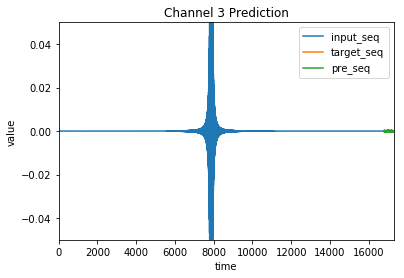

<Figure size 7200x720 with 0 Axes>

In [155]:
           '''Visualization of predicted time series'''
in_seq = reg_data.ix[:,i][endix:endix+w]
tar_seq = reg_data.ix[:,i][endix+w:endix+w+p_w]
predicted_seq = predicted_seq.reshape((p_w))
d = {'time': reg_data.ix[:,i][endix+w:endix+w+p_w], 'values': predicted_seq}
df_sine_pre = pd.DataFrame(data=d)
pre_seq = df_sine_pre['values']

plt.plot(in_seq)
plt.plot(tar_seq)
plt.plot(pre_seq)
plt.ylim(top=.05)
plt.ylim(bottom=-.05)

plt.title('Channel 3 Prediction')
plt.ylabel('value')
plt.xlabel('time')
plt.legend(['input_seq', 'target_seq', 'pre_seq'], loc='upper right')
axes = plt.gca()
axes.set_xlim([endix,endix+w+p_w])
fig_predict = plt.figure(figsize=(100,10))
fig_predict.savefig('predicted_sequence.png')
plt.show()    


Epoch 1/500
5/5 [==============================] - 0s 60ms/step - loss: 17.2053
Epoch 2/500
5/5 [==============================] - 0s 599us/step - loss: 17.0966
Epoch 3/500
5/5 [==============================] - 0s 800us/step - loss: 16.9761
Epoch 4/500
5/5 [==============================] - 0s 800us/step - loss: 16.8562
Epoch 5/500
5/5 [==============================] - 0s 993us/step - loss: 16.7356
Epoch 6/500
5/5 [==============================] - 0s 600us/step - loss: 16.6270
Epoch 7/500
5/5 [==============================] - 0s 600us/step - loss: 16.5264
Epoch 8/500
5/5 [==============================] - 0s 600us/step - loss: 16.4241
Epoch 9/500
5/5 [==============================] - 0s 1000us/step - loss: 16.3190
Epoch 10/500
5/5 [==============================] - 0s 601us/step - loss: 16.2092
Epoch 11/500
5/5 [==============================] - 0s 607us/step - loss: 16.1016
Epoch 12/500
5/5 [==============================] - 0s 593us/step - loss: 15.9974
Epoch 13/500
5/5 [======

Epoch 99/500
5/5 [==============================] - 0s 399us/step - loss: 11.4383
Epoch 100/500
5/5 [==============================] - 0s 800us/step - loss: 11.3941
Epoch 101/500
5/5 [==============================] - 0s 600us/step - loss: 11.3405
Epoch 102/500
5/5 [==============================] - 0s 600us/step - loss: 11.2914
Epoch 103/500
5/5 [==============================] - 0s 402us/step - loss: 11.2523
Epoch 104/500
5/5 [==============================] - 0s 199us/step - loss: 11.2085
Epoch 105/500
5/5 [==============================] - 0s 800us/step - loss: 11.1756
Epoch 106/500
5/5 [==============================] - 0s 399us/step - loss: 11.1256
Epoch 107/500
5/5 [==============================] - 0s 400us/step - loss: 11.0851
Epoch 108/500
5/5 [==============================] - 0s 400us/step - loss: 11.0343
Epoch 109/500
5/5 [==============================] - 0s 599us/step - loss: 10.9816
Epoch 110/500
5/5 [==============================] - 0s 400us/step - loss: 10.9293
Epoch

Epoch 199/500
5/5 [==============================] - 0s 400us/step - loss: 3.0994
Epoch 200/500
5/5 [==============================] - 0s 1ms/step - loss: 3.0309
Epoch 201/500
5/5 [==============================] - 0s 400us/step - loss: 2.9497
Epoch 202/500
5/5 [==============================] - 0s 399us/step - loss: 2.9218
Epoch 203/500
5/5 [==============================] - 0s 400us/step - loss: 2.8714
Epoch 204/500
5/5 [==============================] - 0s 199us/step - loss: 2.7751
Epoch 205/500
5/5 [==============================] - 0s 399us/step - loss: 2.7752
Epoch 206/500
5/5 [==============================] - 0s 400us/step - loss: 2.6831
Epoch 207/500
5/5 [==============================] - 0s 400us/step - loss: 2.5821
Epoch 208/500
5/5 [==============================] - 0s 399us/step - loss: 2.5369
Epoch 209/500
5/5 [==============================] - 0s 199us/step - loss: 2.4506
Epoch 210/500
5/5 [==============================] - 0s 400us/step - loss: 2.4100
Epoch 211/500
5/5 

Epoch 299/500
5/5 [==============================] - 0s 400us/step - loss: 1.7315
Epoch 300/500
5/5 [==============================] - 0s 399us/step - loss: 1.8946
Epoch 301/500
5/5 [==============================] - 0s 200us/step - loss: 1.7569
Epoch 302/500
5/5 [==============================] - 0s 600us/step - loss: 1.9396
Epoch 303/500
5/5 [==============================] - 0s 399us/step - loss: 2.0240
Epoch 304/500
5/5 [==============================] - 0s 199us/step - loss: 1.9041
Epoch 305/500
5/5 [==============================] - 0s 400us/step - loss: 1.7803
Epoch 306/500
5/5 [==============================] - 0s 399us/step - loss: 1.8601
Epoch 307/500
5/5 [==============================] - 0s 400us/step - loss: 1.7428
Epoch 308/500
5/5 [==============================] - 0s 400us/step - loss: 1.8862
Epoch 309/500
5/5 [==============================] - 0s 399us/step - loss: 1.9450
Epoch 310/500
5/5 [==============================] - 0s 400us/step - loss: 1.8217
Epoch 311/500
5/

Epoch 399/500
5/5 [==============================] - 0s 400us/step - loss: 1.6448
Epoch 400/500
5/5 [==============================] - 0s 600us/step - loss: 1.6052
Epoch 401/500
5/5 [==============================] - 0s 1ms/step - loss: 1.7944
Epoch 402/500
5/5 [==============================] - 0s 400us/step - loss: 1.5939
Epoch 403/500
5/5 [==============================] - 0s 400us/step - loss: 1.6558
Epoch 404/500
5/5 [==============================] - 0s 399us/step - loss: 1.6429
Epoch 405/500
5/5 [==============================] - 0s 400us/step - loss: 1.6307
Epoch 406/500
5/5 [==============================] - 0s 399us/step - loss: 1.6345
Epoch 407/500
5/5 [==============================] - 0s 399us/step - loss: 1.6098
Epoch 408/500
5/5 [==============================] - 0s 599us/step - loss: 1.6206
Epoch 409/500
5/5 [==============================] - 0s 400us/step - loss: 1.5918
Epoch 410/500
5/5 [==============================] - 0s 400us/step - loss: 1.5798
Epoch 411/500
5/5 

Epoch 499/500
5/5 [==============================] - 0s 200us/step - loss: 1.4914
Epoch 500/500
1/1 [==============================] - 0s 74ms/step
[[ 93.776695 -81.86888 ]]


In [38]:
               """Save Weights (ShallowAnT)"""
# save it to disk so we can load it back up anytime
model.save_weights('shallow_ch_1_weights.h5')  

In [39]:
"""
Determins whether a sequence exceeds the threshold for being an anomaly

return boolean value of whether the sequence is an anomaly or not
"""
def anomaly_detector(prediction_seq, ground_truth_seq):
    # calculate Euclidean between actual seq and predicted seq
    dist = np.linalg.norm(ground_truth_seq - prediction_seq)  
    if (dist > anm_det_thr):
        return true  # anomaly
    else:
        return false # normal 